Welcome! In this notebook we'll walk through a simple example of how to create a normalizing flow in JAX using Flax!

In [73]:
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from IPython.display import clear_output

%matplotlib inline

First, we'll load a dataset of 10,000 2-dimensional points into a matrix $X \in \mathbb{R}^{10000 \times 2}$.

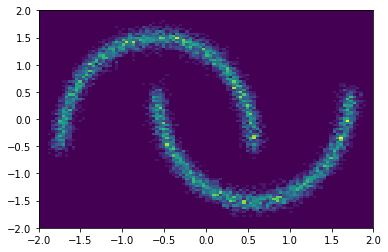

In [74]:
n_samples = 10000
scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = scaler.fit_transform(X)
plt.hist2d(X[:, 0], X[:, 1], bins=100, range=[(-2, 2), (-2, 2)])[-1]

In [75]:
import flax

from jax import grad, jit, random
from jax.experimental import optimizers

Next, we'll define some training parameters.

In [94]:
rng = random.PRNGKey(0)
input_shape = X.shape[1:]
num_epochs, batch_size = 1000, 100

Now it's time to construct the normalizing flow model. We'll opt for a masked autoregressive flow (`MAF`) composed of a sequence of 5 `MADE` blocks.

The core of this library is the concept of _transformations_. Conceptually, a transformation is just an invertible function parameterized by a vector $\theta$, meaning you can call both $f_\theta(x)$ and $f^{-1}_\theta(x)$ such that for all $x \in \mathbb{R}^N$, $x = f^{-1}_\theta(f_\theta(x))$. All transformations follow a common interface, as described next. But it's worth noting that the composition of multiple transformations, retrieved by a call to `serial`, is simply another bigger transformation, meaning it adheres to the exact same transformation interface and is indistinguishable from any other transformation.

When you create a transformation by calling something like `serial(...)`, it returns an initialization function `init_fun`. Given a source of randomness `rng` and an `input_shape` tuple, it will return a tuple `(params, normalizing_fun, generative_fun)`. `params` is consistent with the rest of JAX, and is just a tree of numpy matrices containing all of the trainable parameters of the transformation. More importantly, the `normalizing_fun` and `generative_fun` are the functions which perform the transformation of choice, taking the parameters of the transformation and some inputs you want transformed and returns `(outputs, logdet)`.

In [95]:
init_fun = flax.serial(*(flax.MADE(), flax.Reverse()) * 5)
params, normalizing_fun, generative_fun = init_fun(rng, input_shape)

Now, given the model, we can start to optimize it. We can do this by creating a regular JAX Adam optimizer, supplying it the model parameters.

In [96]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
opt_state = opt_init(params)

In [97]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

Now, we'll write the step function which will update parameters given a batch, and compile it.

In [98]:
@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    return opt_update(i, grad(NLL)(params, normalizing_fun, inputs), opt_state)

And now we train!

In [99]:
itercount = itertools.count()

for epoch in range(num_epochs):
    clear_output(wait=True)

    npr.shuffle(X)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
     
    # Sample
    params = get_params(opt_state)
    Z = npr.normal(0., 1., X.shape)
    X_syn, _ = generative_fun(params, Z)
    
    # Plot
    plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=100, range=[(-2, 2), (-2, 2)])[-1]
    plt.show()   
params = get_params(opt_state)

KeyboardInterrupt: 

_Magic._